In [2]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [ ]:
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.target
tr = tr.drop(columns='target')

order_id = tst.order_id
tst = tst.drop(columns='order_id')


tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

tst = create_time_features(tst)
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from itertools import combinations

def add_prediction_features(df: pd.DataFrame, model_cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    preds = df[model_cols]
    
    # 1) Агрегаты
    df['p_mean']   = preds.mean(axis=1)
    df['p_min']    = preds.min(axis=1)
    df['p_max']    = preds.max(axis=1)
    df['p_median'] = preds.median(axis=1)
    df['p_std']    = preds.std(axis=1)
    
    # 2) Ранговые признаки
    ranks = preds.rank(axis=1, method='average')
    for col in model_cols:
        df[f'{col}_rank'] = ranks[col]
    
    # 3) Попарные абсолютные разности
    for a, b in combinations(model_cols, 2):
        df[f'diff_{a}_{b}'] = (preds[a] - preds[b]).abs()
    
    # 4) Энтропия (нормализуем строки)
    probs = preds.values
    row_sums = probs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    probs_norm = probs / row_sums
    df['p_entropy'] = entropy(probs_norm.T)
    
    return df

tr = add_prediction_features(tr, ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])
tst = add_prediction_features(tst, ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

In [20]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

def add_knn_prediction_features(df: pd.DataFrame, model_cols: list[str], k: int = 5) -> pd.DataFrame:
    df = df.copy()
    X = df[model_cols].values

    # Обучаем KNN
    knn = NearestNeighbors(n_neighbors=k + 1, metric='euclidean')  # +1, т.к. включается сам объект
    knn.fit(X)
    distances, indices = knn.kneighbors(X)
    print('кнн готов')

    # Убираем "себя" (первый индекс — сам объект)
    neighbor_indices = indices[:, 1:]

    # Агрегируем вероятности ближайших соседей
    knn_mean = []
    knn_std = []
    knn_min = []
    knn_max = []
    knn_median = []
    knn_entropy = []

    for i, neigh_ids in enumerate(neighbor_indices):
        neigh_probs = df.iloc[neigh_ids][model_cols].values

        knn_mean.append(neigh_probs.mean())
        knn_std.append(neigh_probs.std())
        knn_min.append(neigh_probs.min())
        knn_max.append(neigh_probs.max())
        knn_median.append(np.median(neigh_probs))
        row_sums = neigh_probs.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        neigh_probs_norm = neigh_probs / row_sums
        knn_entropy.append(entropy(neigh_probs_norm.T).mean())
    

    # Добавляем новые признаки
    df[f'knn_{k}_mean']   = knn_mean
    df[f'knn_{k}_std']    = knn_std
    df[f'knn_{k}_min']    = knn_min
    df[f'knn_{k}_max']    = knn_max
    df[f'knn_{k}_median'] = knn_median
    df[f'knn_{k}_entropy'] = knn_entropy

    return df

tr = add_knn_prediction_features(tr, ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])
tst = add_knn_prediction_features(tst, ['model_1', 'model_2', 'model_3', 'model_4', 'model_5'])

кнн готов
кнн готов


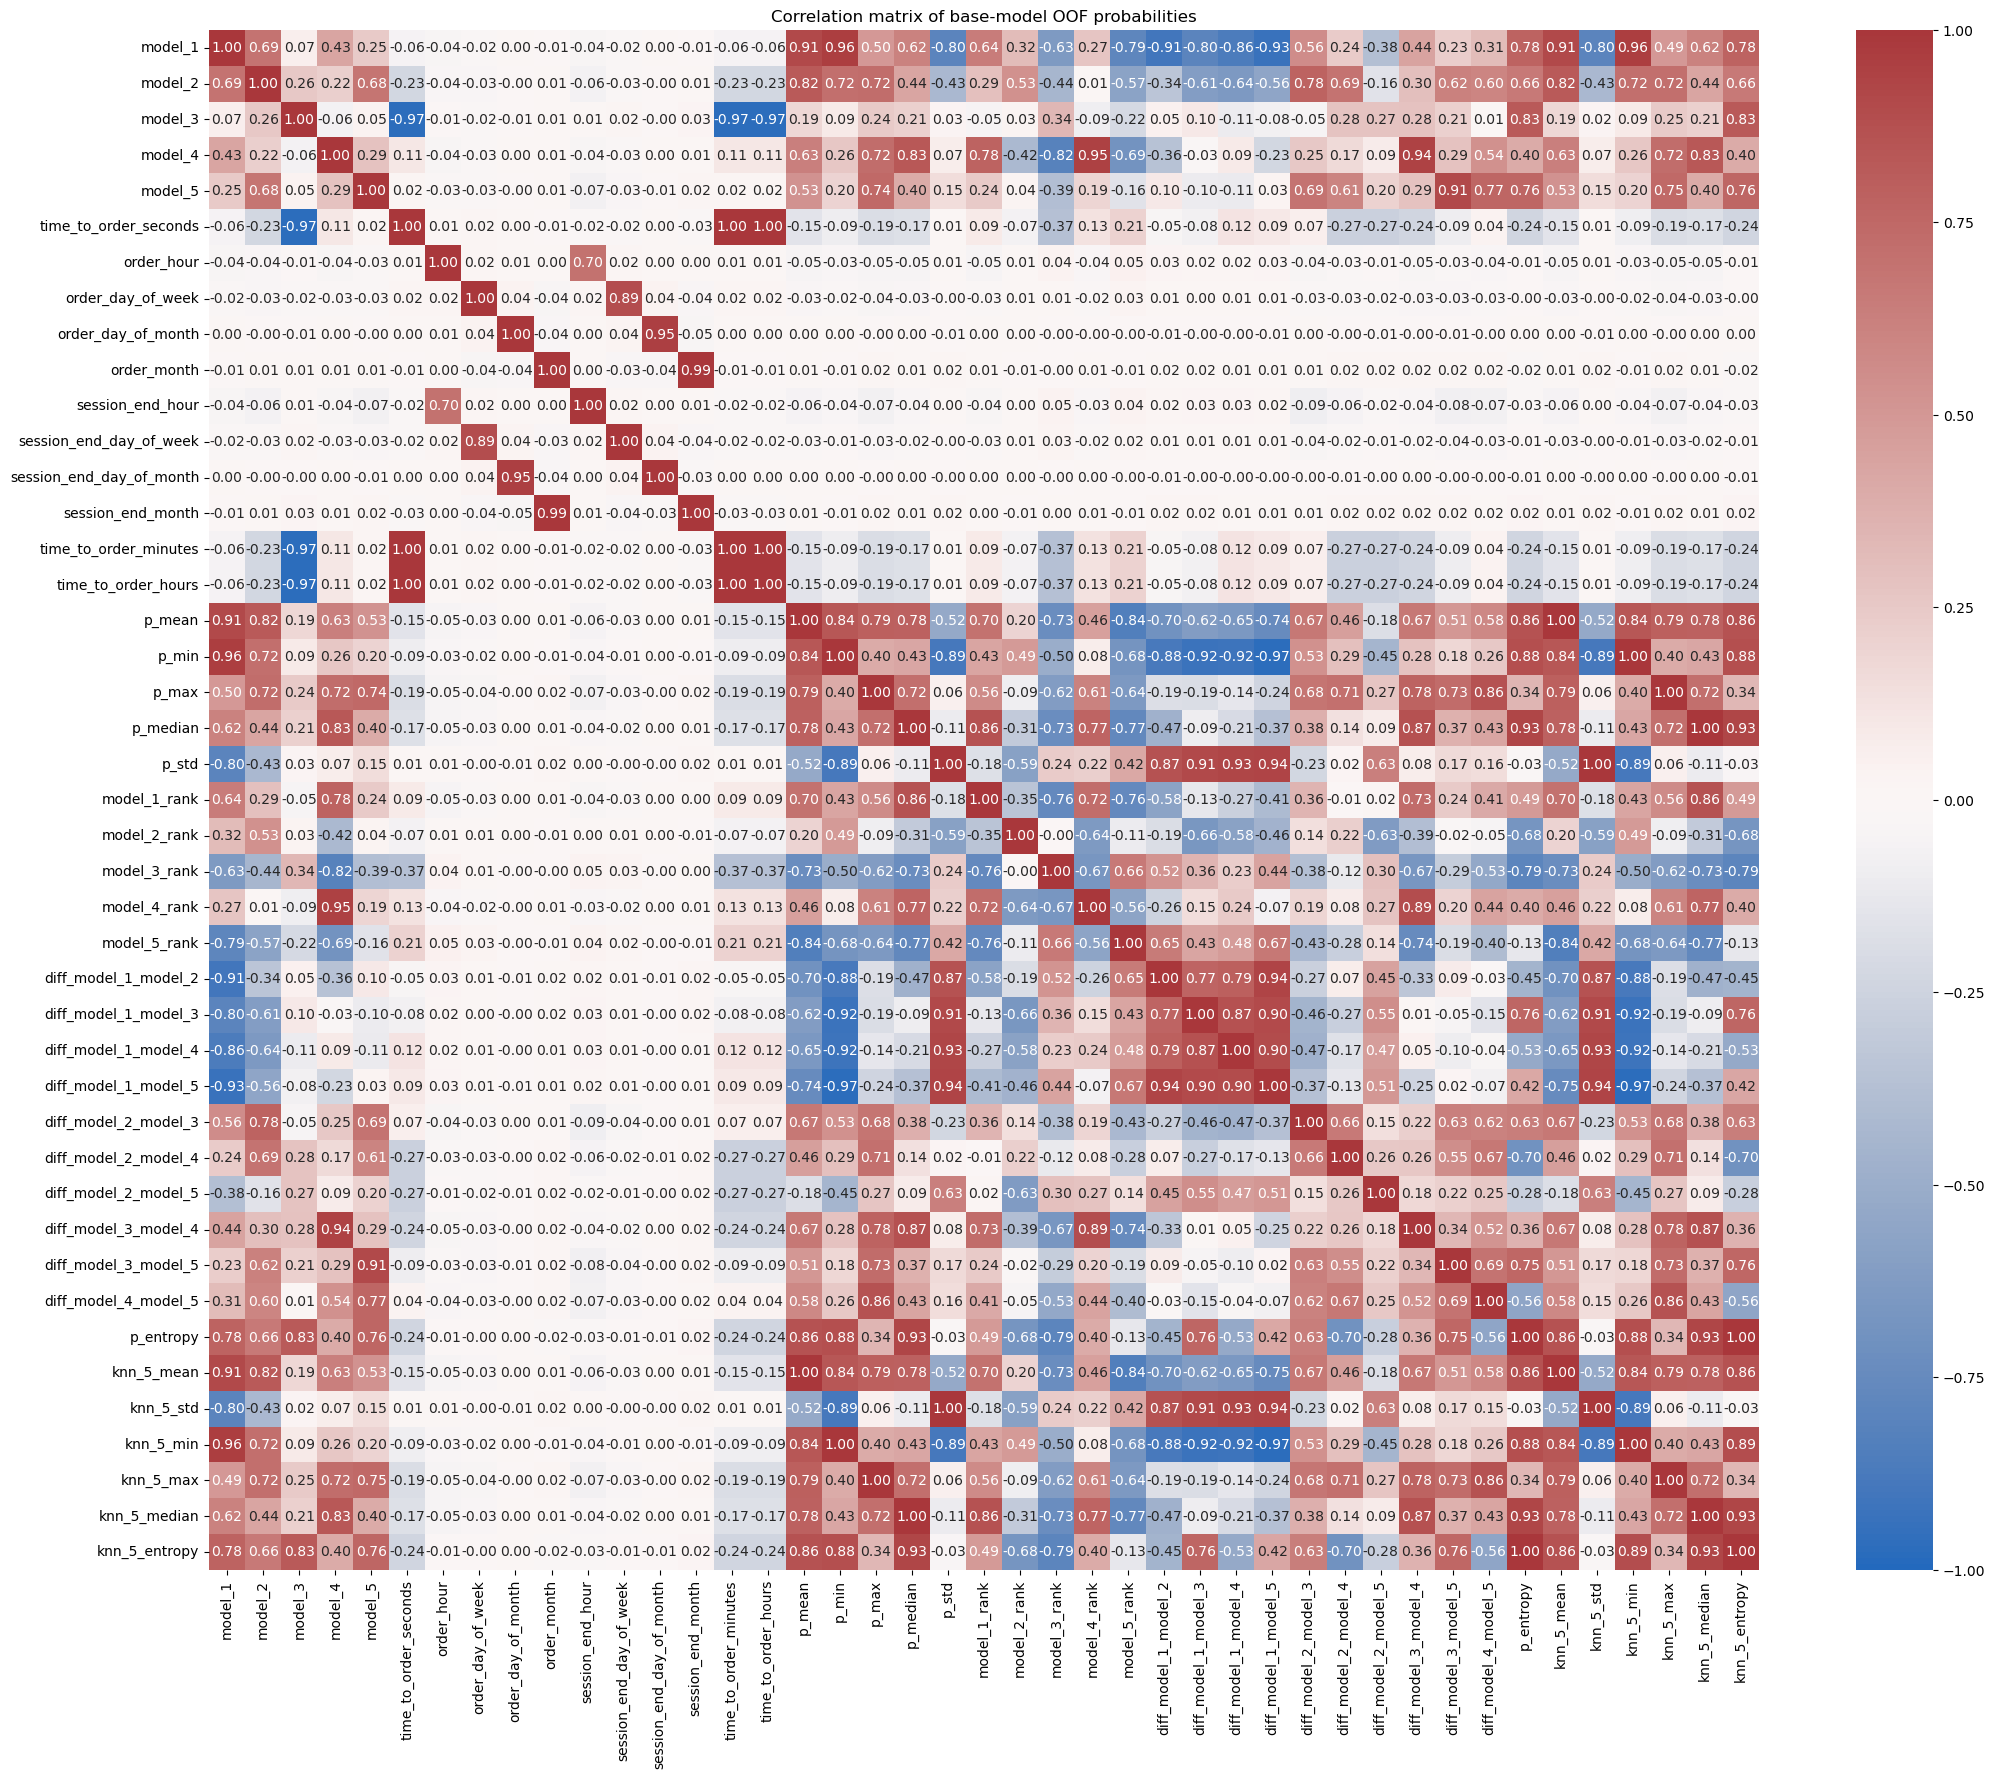

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols = tr.select_dtypes(include=['int', 'float']).columns.tolist()

# 1. Считаем корреляционную матрицу
corr = tr[cols].corr()

# 2. Визуализируем
plt.figure(figsize=(25,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation matrix of base-model OOF probabilities")
plt.show()


In [27]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

categorical_features = [
    'order_time_of_day', 
    'session_end_time_of_day',
    'order_season',
    'session_end_season',
    'order_is_weekend',
    'session_end_is_weekend',
    'same_day_order'
]

for col in ['order_season', 'session_end_season']:
    tr[col] = tr[col].astype('category')
    tst[col] = tst[col].astype('category')


# Разделим train на train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    tr, target, test_size=0.2, random_state=42, stratify=target
)

print(X_train.shape)

# Создадим датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data, categorical_feature=categorical_features)

# Параметры модели (можно настроить)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'early_stopping_round': 50
}

# Обучение модели
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	]
)

# Предсказание на валидации
val_pred = model.predict(X_valid)
val_auc = roc_auc_score(y_valid, val_pred)
print(f'Validation AUC: {val_auc:.4f}')

# Предсказание на тесте
test_pred = model.predict(tst)

# Сохранение результатов
submission = pd.DataFrame({
    'order_id': order_id,
    'target': test_pred
    
})


submission.to_csv('fuck_this_shit.csv', index=False)

(83676, 52)
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.957683	valid's auc: 0.954744
[100]	train's auc: 0.960772	valid's auc: 0.955921
[150]	train's auc: 0.963703	valid's auc: 0.956369
[200]	train's auc: 0.966017	valid's auc: 0.956664
[250]	train's auc: 0.968002	valid's auc: 0.956616
Early stopping, best iteration is:
[221]	train's auc: 0.966861	valid's auc: 0.956717
Validation AUC: 0.9567
